In [7]:
import torch
import math
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import TensorDataset
from collections import OrderedDict
from math import pi
import matplotlib.pyplot as plt

In [11]:
class DrawSpirograph(nn.Module):

    all_params = {'m', 'b', 'h', 'sigma', 'rfore', 'rback', 'gfore', 'gback', 'bfore', 'bback'}

    def __init__(self, data_params, transform_params, m_bounds=(2, 5), b_bounds=(.1, 1.1), h_bounds=(.5, 2.5),
                 sigma_bounds=(.25, 1), rgb_fore_bounds=(.4, 1), rgb_back_bounds=(0, .6), train_proportion = 1.0):
        assert set(data_params) | set(transform_params) == DrawSpirograph.all_params
        assert set(data_params) & set(transform_params) == set()
        super().__init__()
        self.data_params = data_params
        self.transform_params = transform_params
        self.bounds = OrderedDict([
            ('m', m_bounds),
            ('b', b_bounds),
            ('h', h_bounds),
            ('sigma', sigma_bounds),
            ('rfore', rgb_fore_bounds),
            ('rback', rgb_back_bounds),
            ('gfore', rgb_fore_bounds),
            ('gback', rgb_back_bounds),
            ('bfore', rgb_fore_bounds),
            ('bback', rgb_back_bounds)
        ])
        self.train_proportion = train_proportion

    def dataset(self, train_length= 5000, test_length= 1000, device='cpu'):
        train_length= int(train_length*self.train_proportion)
        test_length= int(test_length*self.train_proportion)
        params = []
        for label, bound in self.bounds.items():
            if label in self.data_params:
                params.append(torch.ones(train_length + test_length, device=device).uniform_(bound[0], bound[1]))

        dataset_parameters = torch.stack(params, dim=-1)

        trainset = (dataset_parameters[:train_length, ...], dataset_parameters[:train_length, ...])
        testset = (dataset_parameters[train_length:, ...], dataset_parameters[train_length:, ...])

        return trainset, testset

    def sample_random_numbers(self, shape, device):
        B = shape[0]
        params = []
        for label, bound in self.bounds.items():
            if label in self.transform_params:
                params.append(torch.ones(B, device=device).uniform_(bound[0], bound[1]))

        aug_parameters = torch.stack(params, dim=-1).requires_grad_(True)

        return aug_parameters

    def forward(self, data_params, transform_params):

        # Match up the columns with the right labels
        i, j = 0, 0
        all_params = {}
        for label in self.bounds.keys():
            if label in self.data_params:
                all_params[label] = data_params[..., i]
                i += 1
            elif label in self.transform_params:
                all_params[label] = transform_params[..., j]
                j += 1

        a = all_params['m'] + all_params['b'] - all_params['h']
        b = all_params['b']
        h = all_params['h']
        t = torch.linspace(0, 2 * pi, 40, device=a.device).unsqueeze(-1)
        # x, y, have shape 40, B
        x = (a - b) * torch.cos(t) + h * torch.cos(t * (a - b) / b)
        y = (a - b) * torch.sin(t) - h * torch.sin(t * (a - b) / b)
        # grid has shape 2, 32, 32
        grid = torch.stack(torch.meshgrid(torch.linspace(-6, 6, 32), torch.linspace(-6, 6, 32)), dim=0).to(a.device)
        # centres has shape 40, B, 2, 1, 1
        centres = torch.stack([x, y], axis=-1).unsqueeze(-1).unsqueeze(-1)
        # d has shape 40, B, 32, 32
        d = ((grid - centres) ** 2).sum(2)
        weights = torch.exp(-d / all_params['sigma'].unsqueeze(-1).unsqueeze(-1))
        # v has shape B, 32, 32
        v = weights.mean(0)
        v = v / (v.max(dim=-1, keepdim=True)[0].max(dim=-1, keepdim=True)[0] + 1e-8)

        # Colours have shape B, 3
        col_fore_rgb = torch.stack([all_params['rfore'], all_params['gfore'], all_params['bfore']], dim=-1)
        col_back_rgb = torch.stack([all_params['rback'], all_params['gback'], all_params['bback']], dim=-1)
        col_fore_rgb = col_fore_rgb.unsqueeze(-1).squeeze(-1)
        col_back_rgb = col_back_rgb.unsqueeze(-1).squeeze(-1)

        v = v.unsqueeze(1)
        rgb = v * col_fore_rgb.unsqueeze(-1).unsqueeze(-1) + (1 - v) * col_back_rgb.unsqueeze(-1).unsqueeze(-1)

        return rgb


In [12]:
def get_spirograph_dataset():

    spirograph = DrawSpirograph(['m', 'b', 'sigma', 'rfore'], ['h', 'rback', 'gfore', 'gback', 'bfore', 'bback'])
    trainset, testset = spirograph.dataset()
    return trainset, testset, spirograph

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_gen_param, test_gen_param, spirograph = get_spirograph_dataset()
aug_param = spirograph.sample_random_numbers(train_gen_param[0].shape, device)
with torch.no_grad():
    X = spirograph(train_gen_param[0].to(device), aug_param )
    y = torch.cat([train_gen_param[1].to(device), aug_param], dim = 1)
    store = [(X,y)]
    X, y = zip(*store)
    X, y = torch.cat(X, dim=0), torch.cat(y, dim=0)

data = TensorDataset(X,y)
if not os.path.isdir('dataset'):
    os.mkdir('dataset')
destination = os.path.join('./dataset', 'spirograph')
torch.save(data, destination)

In [14]:
def show(img):
    plt.figure()
    npimg = img.numpy()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    

tensor([3.6010, 0.6918, 0.8415, 0.5112, 0.7784, 0.0144, 0.8474, 0.2762, 0.9931,
        0.3797], device='cuda:0')


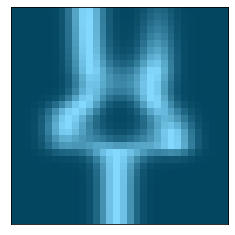

In [15]:
print(y[0])
show(X[0].cpu())